# Raport z projektu 2 - klasteryzacja
Grupa: Kacper Staroń, Jakub Szypuła, Anna Urbala

## Wstęp teoretyczny

### Na czym polega klasteryzacja?
Klasteryzacja polega na szukaniu skupień w zbiorze. Pozwala znaleźć naturalne podziały, wyodrębnić pewne struktury.

### Przykładowe algorytmy
Jednymi z najbardziej popularnych algorytmów są:

- **K-means** - iteracyjnie przypisuje punkty do skupień (do punktów wybranych jako środki), na podstawie otrzymanych skupień wylicza nowe ich środki; trzeba samemu dobrać liczbę skupień
- **hierarchiczne** (z różnymi typami połączeń klastrów) - dzieli istniejące klastry na kolejne klastry, póki odległość między nimi nie jest za mała (odległość zależy od typu połączenia, minimalną odległość można zdefiniować samemu)
- **DBSCAN** - znajduje punkty o wysokiej gęstości i na ich podstawie rozszerza klastry

### Ocena *jakości* klastrowania
Istnieje wiele różnych metryk oceny jakości klastrowania. Każda z nich zwraca uwagę na coś innego, dlatego powinny być dobierane na podstawie tego, co chcemy osiągnąć przez klastrowanie. Oto kilka przykładów:

- **metryka silhouette** - mierzy, jak dobrze pasują punkty do klastrów, niestety premiuje okrągłe klastry
- **indeks Daviesa-Bouldina** - miara podobieństwa klastra z najbardziej podobnym klastrem, podobieństwo liczone na podstawie odległości między klastrami i wewnątrz klastrów
- **różne miary odnośnie odległości między klastrami/w klastrze** - porównanie różnych miar (średnia ogległość między klastrami, najmniejsza odległość między klastrami, odległość punktu od środka klastra) daje nam pewną możliwość oceny klastrowania z uwzględnieniem parametrów, na których nam najbardziej zależy


## Opis zbioru danych
Wybrany przez nas zbiór danych to: [A study of Asian Religious and Biblical Texts Data Set](https://archive.ics.uci.edu/ml/datasets/A+study+of++Asian+Religious+and+Biblical+Texts). Dotyczy świętych tekstów różnych religii.

Składa się z 3 plików dotyczących tych samych danych, ale w innym formacie.

- `Complete_data .txt` - zawiera nieobrobiony tekst ksiąg
- `AllBooks_baseline_DTM_Unlabelled.csv` - tekst ksiąg w reprezentacji *bag-of-words* - słowa to kolumny, księgi wiersze, wartości w komórkach to liczba wystąpień danego słowa w księdze
- `AllBooks_baseline_DTM_Labelled.csv` - jak wyżej, ale z podpisem ksiąg

## Cel projektu
Celem projektu jest znalezienie sensownego podziału między księgami. Być może podział ten będzie w jakimś stopniu zgodny z podziałem na religie.

## Opis rozwiązania
Pierwszym problemem, który musieliśmy rozwiązać była obróbka oryginalnego tekstu. Niestety przez to, że pewne słowa występują bardzo rzadko, mogło być dość problematyczne operowanie na całej tabeli *AllBooks_baseline_DTM_Unlabelled*. Postanowiliśmy położyć pewien nacisk na zliczenie częstotliwości występowania słów w księgach.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\finwe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


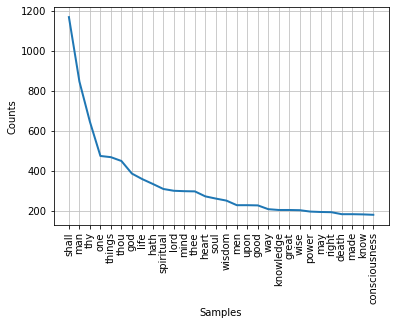

In [195]:
f = open('AsianReligionsData/Complete_data .txt')
content = f.read()
lines = content.split("\n")
data = []

# wybranie tylko linii z danymi
for i in range(len(lines)):
    if i % 2 == 1:
        data.append(lines[i])

f.close()

import nltk
from nltk.probability import FreqDist

# najczestsze slowa

def tokenize(text):
    words = nltk.word_tokenize(text)
    return [word.lower() for word in words if word.isalpha()]

def word_frequency(words):
    return FreqDist(words)

# stop words, ktore nalezy odfiltrowac
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

# Czestotliwosci zsumowane ze wszystkich ksiag

data_str = " ".join(data)
words_str = tokenize(data_str)
filtered_words_str = [word for word in words_str if word not in stop_words]
filtered_freq_str = word_frequency(filtered_words_str)
filtered_freq_str.plot(30, cumulative=False)

Powyższy wykres zasugerował nam również, że porównywanie słów poza TOP ok. 30-50 pod kątem częstotliwości prawdopodobnie nie ma sensu, gdyż nie będą występowały w prawie żadnej księdze. Być może warto spróbować porównywania korpusów.

Zainteresowało nas również, jakie słowa są najpopularniejsze w zależności od księgi.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\finwe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\finwe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


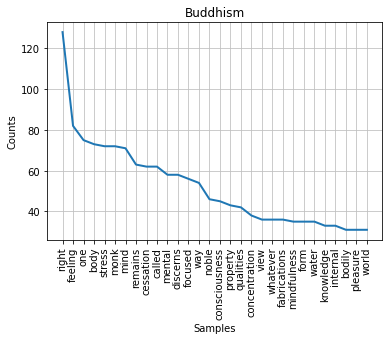

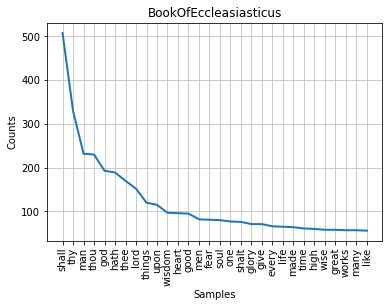

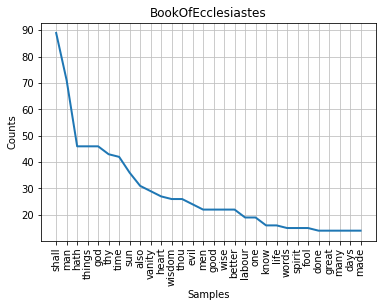

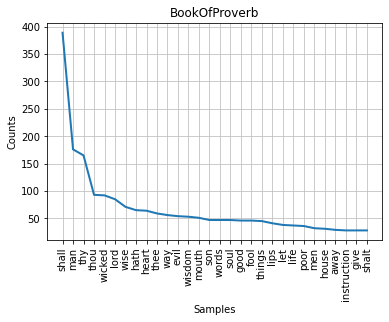

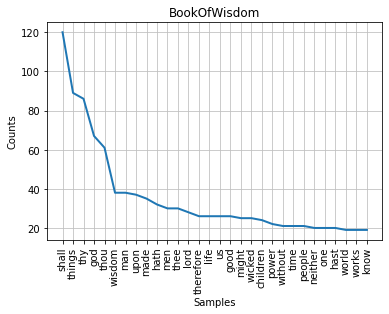

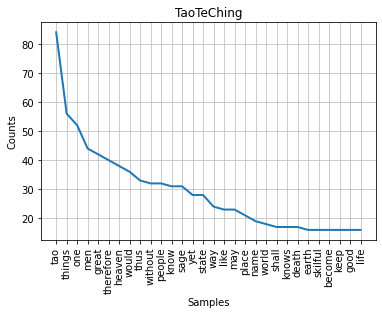

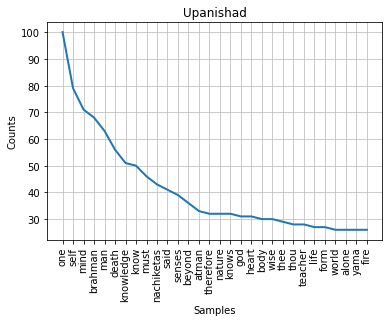

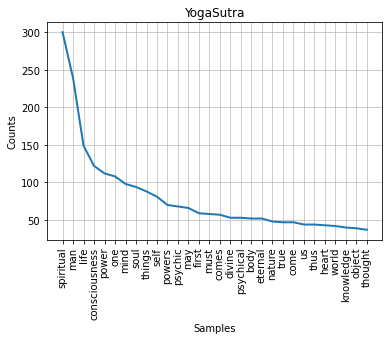

In [196]:
import re
f = open('AsianReligionsData/labels.txt')
lcontent = f.read()
llines = lcontent.split("\n")
labels = []

# wybranie tylko linii z danymi
for l in llines:
    labels.append(l)
        
f.close()
labels.pop()

labels_general = []
for l in labels:
    labels_search = re.search('(.+)_', l)
    labels_general.append(labels_search.group(1))
groups = set(labels_general)

group_ids = {}
for g in groups:
    tmp = [i for i in range(len(labels_general)) if labels_general[i] == g]
    group_ids[g] = tmp

import copy
books = {}
for g in groups:
    tmp = ""
    for i in group_ids[g]:
        tmp += data[i]
    books[g] = copy.copy(tmp)
    
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
# oczyszczenie ze stopwords
stop_words = set(stopwords.words("english"))

categories = ['Buddhism', 'BookOfEccleasiasticus', 'BookOfEcclesiastes', 'BookOfProverb', 'BookOfWisdom', 'TaoTeChing', 'Upanishad', 'YogaSutra']

for category in categories:
    cat_words_str = tokenize(books[category])
    cat_filtered_words_str = [word for word in cat_words_str if word not in stop_words]
    cat_filtered_freq_str = word_frequency(cat_filtered_words_str)
    cat_filtered_freq_str.plot(30, cumulative=False, title=category)

### Jak liczyć odległości?
Zdefiniowaliśmy 2 metody liczenia odległości między klastrami:

- cały tekst (z wyłączeniem stop words) przekształcony do miar TF-IDF i na tych miarach klasyczna odległość euklidesowa
- ograniczenie tekstu do $k$ najczęściej występujących słów (w naszym przypadku przyjęliśmy $k=30$) i na tym analogiczne operacje

In [197]:
import string
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer

def process_whole_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens
    
def get_first_i_without_order(text, i, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
        
    freq = FreqDist(tokens)
    most_comm = freq.most_common(i)
    tokens = [token[0] for token in most_comm]
    
    return tokens

from scipy.spatial import distance
import numpy as np

# def two_class

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

def clusters_num(X, label):
    return len(set(label))

def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

def prepare_X(texts, process_function):
    vectorizer = TfidfVectorizer(tokenizer=process_function,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
 
    return vectorizer.fit_transform(texts)

import pandas as pd
from functools import partial
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import MiniBatchKMeans


metrices = {
            'min dist between clusters': min_interclust_dist,
            'mean dist in clust': mean_inclust_dist,
            'std dev dist in clust': std_dev_of_inclust_dist,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score,
            'davies-bouldin': davies_bouldin_score,
            'clusters num': clusters_num
           }

models = {
          'Agglomerative ward linkage': partial(AgglomerativeClustering, linkage='ward'),
          'Agglomerative complete linkage': partial(AgglomerativeClustering, linkage='complete'),
          'Agglomerative average linkage': partial(AgglomerativeClustering, linkage='average'),
          'Agglomerative single linkage': partial(AgglomerativeClustering, linkage='single'),
          'Mini Batch KMeans': MiniBatchKMeans,
          'Kmeans': KMeans
         }

def calculate_metrics(X, cluster_num):
    df = pd.DataFrame()
    for model_key in models:
        for metric_key in metrices:
            df.loc[model_key, metric_key] = count_clustering_scores(X=X, cluster_num=cluster_num,
                                                                    model=models[model_key],
                                                                    score_fun=metrices[metric_key])
    return df

### Wizualizowanie modeli

Biorąc pod uwagę budowę analizowanego zbioru danych i ilość parametrów, które przetwarzają modele klasterujące, zdecydowaliśmy się zwizualizować efekty ich działania za pomocą t-SNE.

Wykorzystamy do tego dodatkową pomocniczą funkcję plotującą.

In [198]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [199]:
def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 10))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add labels
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txts.append(txt)

    return f, ax, sc, txts

Przygotowanie wizualizacji t-SNE:

In [200]:
X_p = prepare_X(data, partial(get_first_i_without_order, i=30)).toarray()
X_w = prepare_X(data, process_whole_text).toarray()

In [201]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
tsne_results_p = tsne.fit_transform(X_p)
tsne_results_w = tsne.fit_transform(X_w)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 590 samples in 0.007s...
[t-SNE] Computed neighbors for 590 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 590 / 590
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.777054
[t-SNE] KL divergence after 300 iterations: 0.519368
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 590 samples in 0.020s...
[t-SNE] Computed neighbors for 590 samples in 0.101s...
[t-SNE] Computed conditional probabilities for sample 590 / 590
[t-SNE] Mean sigma: 0.347597
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.272812
[t-SNE] KL divergence after 300 iterations: 1.767233


### Wartości metryk dla wstępnych modeli

In [202]:
# Get whole text
X = prepare_X(data, process_whole_text).toarray()
whole_text_metrics = calculate_metrics(X, 3) # dosc dobre wartosci dawalo rowniez n=8
whole_text_metrics

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin,clusters num
Agglomerative ward linkage,0.792830,1.174056,0.119025,0.827009,0.041090,3.334753,3.0
Agglomerative complete linkage,0.672026,1.249152,0.102270,0.882001,0.023263,6.741079,3.0
Agglomerative average linkage,0.852063,1.088455,0.170585,0.723249,0.034598,2.147604,3.0
Agglomerative single linkage,1.000000,NaN,NaN,0.311270,-0.015797,0.985968,3.0
Mini Batch KMeans,0.573614,1.214183,0.126454,0.847949,0.055180,3.716820,3.0
Kmeans,0.567902,1.192302,0.125271,0.842904,0.054020,3.760810,3.0


Wyniki nie są zadowalające, ale modele radzące sobie najlepiej to Agglomerative ward linkage oraz Kmeans. Wizualizację ich klasteryzacji widzimi poniżej:

Text(0.5, 1.0, 'Agglomerative average linkage')

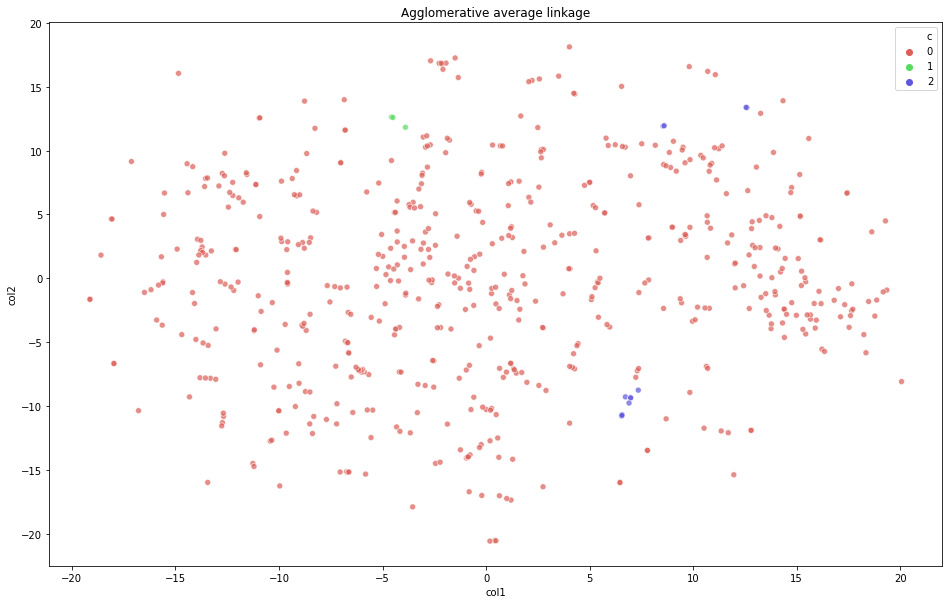

In [203]:
agg_avg = AgglomerativeClustering(n_clusters=3, linkage = 'average')
labels = agg_avg.fit_predict(X_w)

df = pd.DataFrame(data = tsne_results_w, columns = ['col1', 'col2'])

df['c'] = labels
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="col1", y="col2",
    hue="c",
    palette=sns.color_palette("hls", len(set(labels))),
    data=df,
    legend="full",
    alpha=0.7
).set_title("Agglomerative average linkage")

Text(0.5, 1.0, 'KMeans, n=3')

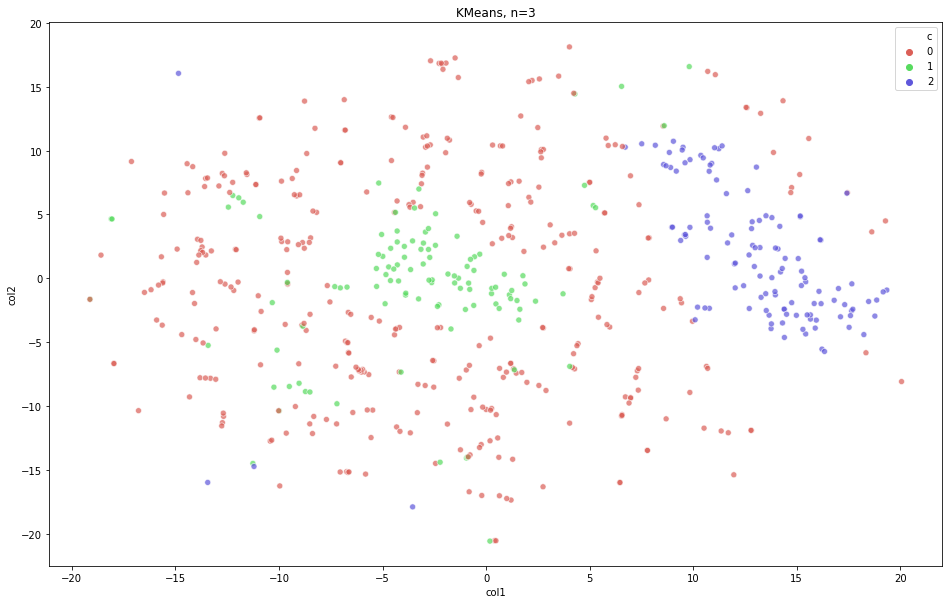

In [204]:
kmeans = KMeans(n_clusters = 3, n_init =100)
labels = kmeans.fit_predict(X_w)

df = pd.DataFrame(data = tsne_results_w, columns = ['col1', 'col2'])

df['c'] = labels
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="col1", y="col2",
    hue="c",
    palette=sns.color_palette("hls", len(set(labels))),
    data=df,
    legend="full",
    alpha=0.7
).set_title("KMeans, n=3")

Warte uwagi było też działanie Kmeans dla 8 klastrów:

Text(0.5, 1.0, 'KMeans, n=8')

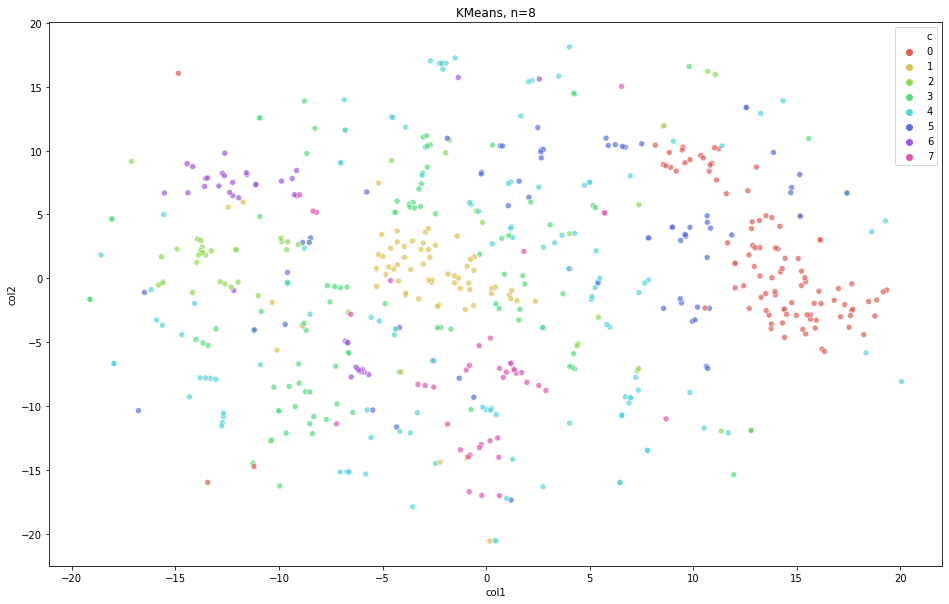

In [205]:
kmeans = KMeans(n_clusters = 8, n_init =10)
labels = kmeans.fit_predict(X_w)

df = pd.DataFrame(data = tsne_results_w, columns = ['col1', 'col2'])

df['c'] = labels
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="col1", y="col2",
    hue="c",
    palette=sns.color_palette("hls", len(set(labels))),
    data=df,
    legend="full",
    alpha=0.7
).set_title("KMeans, n=8")

In [206]:
# Get first 30
X = prepare_X(data, partial(get_first_i_without_order, i=30)).toarray()
calculate_metrics(X, 10)

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin,clusters num
Agglomerative ward linkage,0.478933,0.658365,0.226952,0.488231,0.323363,1.270449,10.0
Agglomerative complete linkage,0.440409,0.696521,0.144138,0.525002,0.276652,1.450325,10.0
Agglomerative average linkage,0.494142,0.595802,0.276128,0.443627,0.298544,1.250900,10.0
Agglomerative single linkage,0.665383,NaN,NaN,0.116205,0.000082,1.239330,10.0
Mini Batch KMeans,0.416448,0.653042,0.215555,0.468991,0.328210,1.167390,10.0
Kmeans,0.414123,0.698824,0.146230,0.480397,0.332675,1.159834,10.0


W przypadku procesowania całego tekstu metryka silhouette dała nam bardzo niskie wartości, w przypadku top 30 słów znacznie lepsze, ale nieco sprzeczne z indeksem Daviesa-Bouldina. Najbardziej wyróżniającym się modelem był Agglomerative ward linkage.

Text(0.5, 1.0, 'Agglomerative ward linkage')

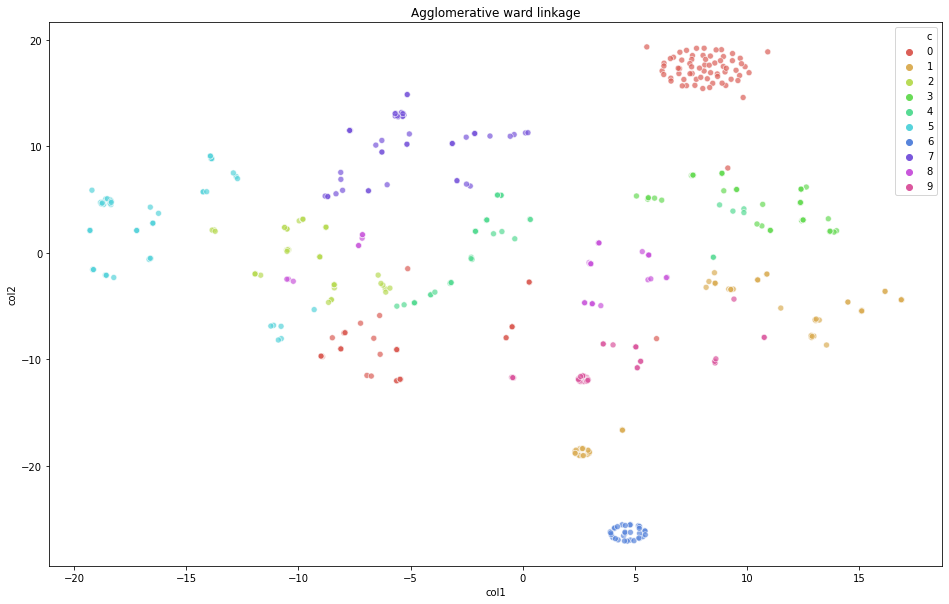

In [207]:
agg_avg = AgglomerativeClustering(n_clusters=10, linkage = 'ward')
labels = agg_avg.fit_predict(X_p)

df = pd.DataFrame(data = tsne_results_p, columns = ['col1', 'col2'])

df['c'] = labels
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="col1", y="col2",
    hue="c",
    palette=sns.color_palette("hls", len(set(labels))),
    data=df,
    legend="full",
    alpha=0.7
).set_title("Agglomerative ward linkage")

Postanowiliśmy jednak sprawdzić jeszcze bardzo popularne algorytmy DBSCAN i GMM.

#### DBSCAN

In [208]:
from sklearn import cluster, mixture

X = prepare_X(data, process_whole_text).toarray()
eps_list = np.arange(0.1, 1, 0.1)
df = pd.DataFrame()
for eps in eps_list:
    dbscan = cluster.DBSCAN(eps=eps)
    labels = dbscan.fit_predict(X)
    df.loc[eps, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[eps, metric_key] =  metrices[metric_key](X, labels)
        except:
            print("failed for ", metric_key, eps)
df

failed for  silhouette 0.1
failed for  davies-bouldin 0.1
failed for  silhouette 0.2
failed for  davies-bouldin 0.2
failed for  silhouette 0.30000000000000004
failed for  davies-bouldin 0.30000000000000004
failed for  silhouette 0.4
failed for  davies-bouldin 0.4


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin
0.1,1.0,inf,1.319530,0.000000,0.933880,NaN,NaN
0.2,1.0,inf,1.319530,0.000000,0.933880,NaN,NaN
0.3,1.0,inf,1.319530,0.000000,0.933880,NaN,NaN
0.4,1.0,inf,1.319530,0.000000,0.933880,NaN,NaN
0.5,2.0,0.533469,0.915165,0.405571,0.633499,-0.030633,1.556112
0.6,3.0,0.548840,0.865496,0.323055,0.596172,-0.022660,1.712393
0.7,5.0,0.633533,0.850090,0.249306,0.573131,-0.029162,1.910902
0.8,7.0,0.649848,0.891919,0.199291,0.601810,-0.005624,2.101353
0.9,10.0,0.710173,1.000851,0.164401,0.677092,0.037307,2.686207


Text(0.5, 1.0, 'DBSCAN eps = 0.9')

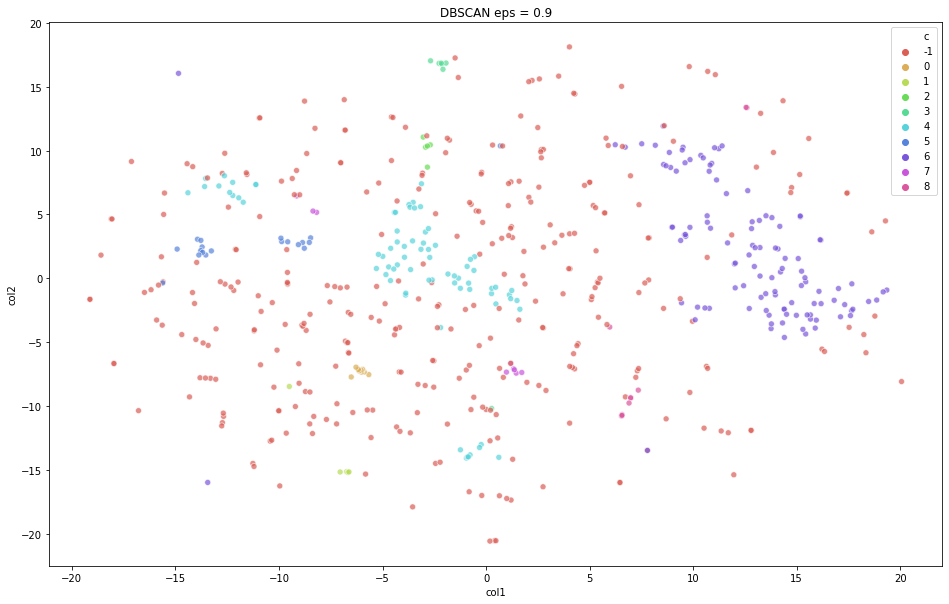

In [209]:
eps = 0.9

dbscan = cluster.DBSCAN(eps=eps)
labels = dbscan.fit_predict(X_w)

df = pd.DataFrame(data = tsne_results_w, columns = ['col1', 'col2'])

df['c'] = labels
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="col1", y="col2",
    hue="c",
    palette=sns.color_palette("hls", len(set(labels))),
    data=df,
    legend="full",
    alpha=0.7
).set_title("DBSCAN eps = 0.9")

In [210]:
X = prepare_X(data, partial(get_first_i_without_order, i=30)).toarray()
eps_list = np.arange(0.1, 1, 0.1)
df = pd.DataFrame()
for eps in eps_list:
    dbscan = cluster.DBSCAN(eps=eps)
    labels = dbscan.fit_predict(X)
    df.loc[eps, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[eps, metric_key] =  metrices[metric_key](X, labels)
        except:
            print("failed for ", metric_key, eps)
df

,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin
0.1,29.0,0.350730,0.041254,0.218298,0.029553,0.385813,0.985460
0.2,29.0,0.350730,0.041254,0.218298,0.029553,0.385813,0.985460
0.3,29.0,0.350730,0.041254,0.218298,0.029553,0.385813,0.985460
0.4,33.0,0.412582,0.067941,0.216107,0.050334,0.419838,1.037136
0.5,40.0,0.380407,0.192560,0.234998,0.148261,0.522180,1.164041
0.6,15.0,0.417129,0.414437,0.405827,0.309569,0.157025,2.062636
0.7,4.0,0.591547,0.566451,0.570819,0.389698,0.001176,1.931544
0.8,3.0,0.838272,0.411164,0.581474,0.295838,0.001540,1.623308
0.9,2.0,1.000000,0.616319,0.616319,0.443617,-0.056503,1.947414


Niestety liczba $>20$ klastrów nas raczej nie interesuje, więc będziemy się raczej trzymać 3-10.

#### GMM

In [34]:
X = prepare_X(data, process_whole_text).toarray()
df = pd.DataFrame()
for n in range(1,10):
    gmm = mixture.GaussianMixture(n_components=n)
    labels = gmm.fit_predict(X)
    df.loc[n, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[n, metric_key] =  metrices[metric_key](X, labels)
        except:
            print("failed for", metric_key, n)
df

failed for silhouette 1
failed for davies-bouldin 1


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin
1,1.0,inf,1.319530,0.000000,0.933880,NaN,NaN
2,2.0,0.767523,1.183476,0.149325,0.835472,0.044869,2.854261
3,3.0,0.637202,1.218418,0.134799,0.860109,0.046390,5.028543
4,4.0,0.567902,1.198903,0.110442,0.844414,0.059237,3.853182
5,5.0,0.567902,1.208471,0.115716,0.851208,0.058867,4.663830
6,6.0,0.611359,1.211113,0.103458,0.852472,0.064037,4.002571
7,7.0,0.611359,1.201482,0.103388,0.844493,0.065044,3.895216
8,8.0,0.567902,1.202501,0.098919,0.844819,0.067398,3.857847
9,9.0,0.445178,1.173179,0.099479,0.822335,0.051533,3.859540


n_components	clusters num	min dist between clusters	mean dist in clust	std dev dist in clust	mean dist to clust center	silhouette	davies-bouldin
1	1.0	inf	1.319530	0.000000	0.933880	NaN	NaN
2	2.0	0.767523	1.183476	0.149325	0.835472	0.044869	2.854261
3	3.0	0.637202	1.218418	0.134799	0.860109	0.046390	5.028543
4	4.0	0.567902	1.198903	0.110442	0.844414	0.059237	3.853182
5	5.0	0.567902	1.208471	0.115716	0.851208	0.058867	4.663830
6	6.0	0.611359	1.211113	0.103458	0.852472	0.064037	4.002571
7	7.0	0.611359	1.201482	0.103388	0.844493	0.065044	3.895216
8	8.0	0.567902	1.202501	0.098919	0.844819	0.067398	3.857847
9	9.0	0.445178	1.173179	0.099479	0.822335	0.051533	3.859540

Text(0.5, 1.0, 'GMM, n=2')

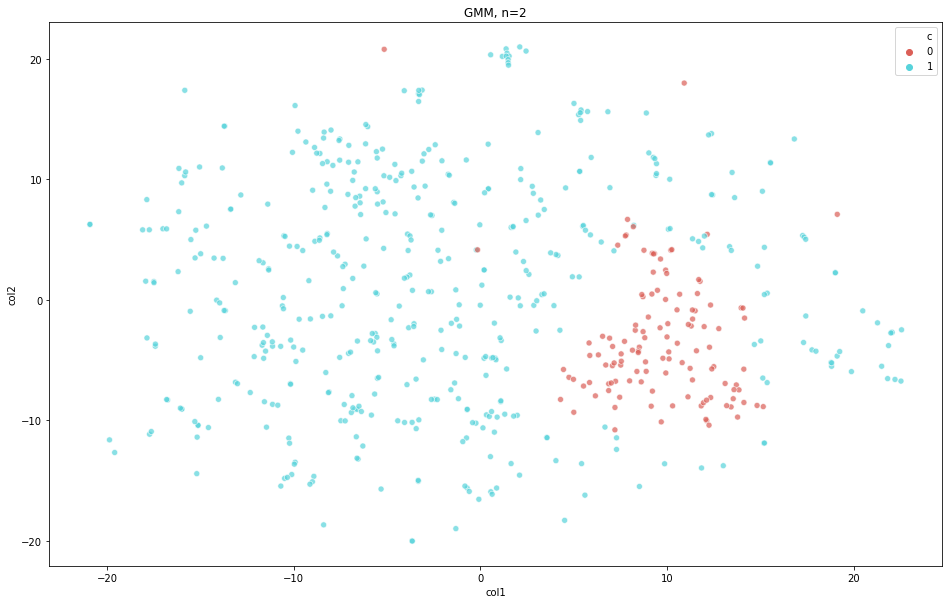

In [47]:
n = 2

gmm = mixture.GaussianMixture(n_components=n)
labels = gmm.fit_predict(X_w)

df = pd.DataFrame(data = tsne_results_w, columns = ['col1', 'col2'])

df['c'] = labels
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="col1", y="col2",
    hue="c",
    palette=sns.color_palette("hls", len(set(labels))),
    data=df,
    legend="full",
    alpha=0.7
).set_title("GMM, n=2")

Text(0.5, 1.0, 'GMM, n=9')

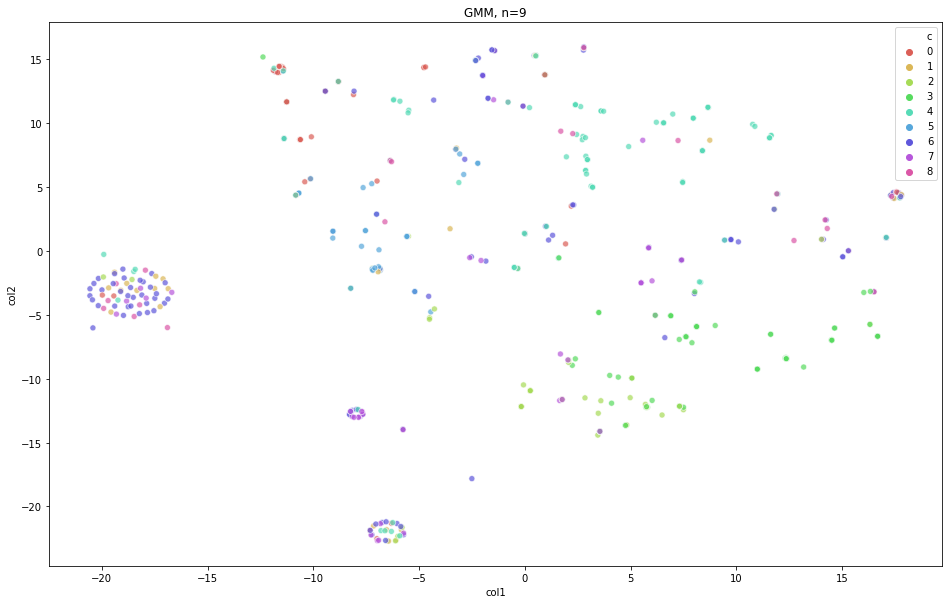

In [48]:
n = 9

gmm = mixture.GaussianMixture(n_components=n)
labels = gmm.fit_predict(X_w)

df = pd.DataFrame(data = tsne_results_p, columns = ['col1', 'col2'])

df['c'] = labels
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="col1", y="col2",
    hue="c",
    palette=sns.color_palette("hls", len(set(labels))),
    data=df,
    legend="full",
    alpha=0.7
).set_title("GMM, n=9")

In [37]:
X = prepare_X(data, partial(get_first_i_without_order, i=30)).toarray()
df = pd.DataFrame()
for n in range(1,10):
    gmm = mixture.GaussianMixture(n_components=n)
    labels = gmm.fit_predict(X)
    df.loc[n, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[n, metric_key] =  metrices[metric_key](X, labels)
        except:
            print("failed for", metric_key, n)
df

failed for silhouette 1
failed for davies-bouldin 1


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin
1,1.0,inf,1.172193,0.000000,0.835972,NaN,NaN
2,2.0,0.463015,1.097145,0.005059,0.790475,0.124465,2.859326
3,3.0,0.390689,0.959672,0.138119,0.691529,0.164824,2.218491
4,4.0,0.373751,0.996944,0.110973,0.734790,0.113205,2.589858
5,5.0,0.478745,0.883482,0.077994,0.639531,0.211663,1.942192
6,6.0,0.391464,0.893198,0.089095,0.656716,0.167301,2.056183
7,7.0,0.448004,0.828404,0.118178,0.609309,0.220890,1.966471
8,8.0,0.404198,0.845730,0.098704,0.624116,0.189627,1.999611
9,9.0,0.488615,0.721362,0.103372,0.531669,0.309927,1.317596


Dla $n=8$ (czyli tyle, ile jest ksiąg!) mamy całkiem sensowne wartości.

Text(0.5, 1.0, 'GMM, n=8')

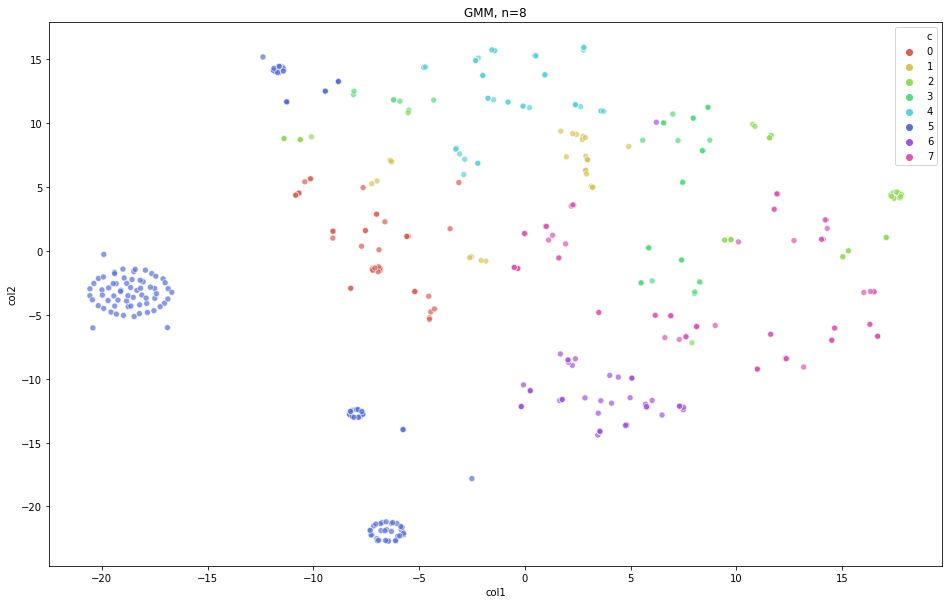

In [49]:
n = 8

gmm = mixture.GaussianMixture(n_components=n)
labels = gmm.fit_predict(X_p)

df = pd.DataFrame(data = tsne_results_p, columns = ['col1', 'col2'])

df['c'] = labels
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="col1", y="col2",
    hue="c",
    palette=sns.color_palette("hls", len(set(labels))),
    data=df,
    legend="full",
    alpha=0.7
).set_title("GMM, n=8")

### Analiza sentymentów
Ponieważ dane z analizowanego zbioru są słowami języka naturalnego, interesujących zależności możemy poszukać stosując analizę sentymentów. Dlatego podeszliśmy do problemu też od innej strony.

In [11]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer


def text_emotion(tekst):
    filepath = ('AsianReligionsData/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    document = word_tokenize(tekst)
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=range(0, len(document)), columns=emotions)
    for i in range(0, len(document)):
        word = document[i]
        emo_score = emolex_words[emolex_words.word == word]
        if not emo_score.empty:
            for emotion in list(emotions):
                emo_df.at[i, emotion] += emo_score[emotion]

    return emo_df

Każdemu rozdziałowi możemy przypisać średnią emocję, tzn. dla każdej z 10 emocji 
* $anger$, 
* $anticipation$, 
* $disgust$, 
* $fear$, 
* $joy$, 
* $negative$, 
* $positive$, 
* $sadness$, 
* $surprise$, 
* $trust$. 

każdemu rozdziałowi przypisujemy średnią emocji danej księgi we wszystkich słowach z tego rozdziału.

In [17]:
from sklearn import preprocessing
tmp = text_emotion(data[0])
tmp = tmp.sum()/tmp.shape[0]
average_sentiments = pd.DataFrame(copy.copy([tmp]))
first = True
for chapter in data:
    if first:
        first = False
    else:
        tmp = text_emotion(chapter)
        tmp = tmp.sum()/tmp.shape[0]
        average_sentiments = average_sentiments.append(copy.copy([tmp]))
for chapter in data:
    if first:
        first = False
    else:
        tmp = text_emotion(chapter)
        tmp = tmp.sum()/tmp.shape[0]
        average_sentiments.append(copy.copy([tmp]))
        
average_sentiments = average_sentiments.rename_axis('chapter_id', axis='columns')
average_sentiments.index = list(range(0, 590))
average_sentiments = pd.DataFrame(preprocessing.normalize(average_sentiments), columns = list(average_sentiments.columns))
average_sentiments.index = labels
average_sentiments.head()

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
Buddhism_Ch1,0.183359,0.150021,0.316711,0.350049,0.250035,0.383387,0.500069,0.316711,0.033338,0.400056
Buddhism_Ch2,0.041776,0.041776,0.083551,0.000000,0.041776,0.626634,0.584858,0.000000,0.041776,0.501307
Buddhism_Ch3,0.055815,0.111629,0.055815,0.186049,0.000000,0.911638,0.241863,0.186049,0.074419,0.130234
Buddhism_Ch4,0.036955,0.092387,0.000000,0.055432,0.036955,0.369548,0.720618,0.036955,0.018477,0.572799
Buddhism_Ch5,0.000000,0.000000,0.000000,0.516398,0.258199,0.516398,0.258199,0.258199,0.000000,0.516398


### Modele

#### Przygotowanie odpowiednich funkcji i danych wejściowych 

In [ ]:
from sklearn import preprocessing

x = average_sentiments.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
average_sentiments2 = pd.DataFrame(x_scaled)

from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters = 8)
etykiety = model.fit_predict(average_sentiments2)
tmp = average_sentiments.iloc[np.where(etykiety==0)]
tmp = tmp.sum()/tmp.shape[0]
cluster_emotions = pd.DataFrame(copy.copy([tmp])) 
for i in range(1, 8):
    tmp = average_sentiments.iloc[np.where(etykiety==i)]
    tmp = tmp.sum()/tmp.shape[0]
    cluster_emotions = cluster_emotions.append(copy.copy([tmp]))

In [100]:
import pandas as pd
from functools import partial
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering


from scipy.spatial import distance
import numpy as np

# def two_class

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X.iloc[cluster_i_idx], axis=0)
        inclust_dist = np.mean(np.sqrt(np.sum((X.iloc[cluster_i_idx] - cluster_i_mean)**2)))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

metrices = {
            'mean dist to clust center': mean_dist_to_center,
            'davies-bouldin': davies_bouldin_score,
            'silhouette': silhouette_score
           }

models = {
          'Agglomerative ward linkage': partial(AgglomerativeClustering, linkage='ward'),
          'Agglomerative complete linkage': partial(AgglomerativeClustering, linkage='complete'),
          'Agglomerative average linkage': partial(AgglomerativeClustering, linkage='average'),
          'Agglomerative single linkage': partial(AgglomerativeClustering, linkage='single'),
          'Mini Batch KMeans': MiniBatchKMeans,
          'Kmeans': KMeans,
          'Spectral Clustering': SpectralClustering,
          'Birch': partial(Birch, threshold = 0.1)
         }

def calculate_metrics(X, cluster_num):
    df = pd.DataFrame()
    for model_key in models:
        for metric_key in metrices:
            df.loc[model_key, metric_key] = count_clustering_scores(X=X, cluster_num=cluster_num,
                                                                    model=models[model_key],
                                                                    score_fun=metrices[metric_key])
    return df

In [94]:
from sklearn.cluster import KMeans
def count_wcss_scores(dane, k_max):
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=121)
        kmeans.fit(dane)
        wcss = kmeans.score(dane) * -1
        scores.append(wcss)
    return scores

In [101]:
import warnings
warnings.filterwarnings('ignore')
k_range = list(range(2,20))
sc_scores = [] # sc = sentiment clustering
for k in k_range:
    sc_scores.append(calculate_metrics(average_sentiments, k))

WCSS dla kolejnych wielkości k.

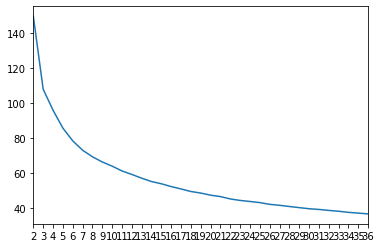

In [102]:
wyniki = pd.Series(count_wcss_scores(average_sentiments, 35))
wyniki.index += 2
plt = wyniki.plot.line(xticks = list(range(2, 37)))
plt

W żadnym momencie wykres nie "wypłaszcza się" znacząco", trudno wybrać odpowiednie k.

### Obliczenie miar dla różnych k

In [103]:
import copy
wcss_scores = {}
sillhoute_scores = {}
idb_scores = {}

for m in list(models.keys()):
    wcss_scores[m] = []
    sillhoute_scores[m] = []
    idb_scores[m] = []

    
for s in sc_scores:
    for m in list(models.keys()):
        wcss_scores[m].append(s.loc[m].iloc[0])
        idb_scores[m].append(s.loc[m].iloc[1])
        sillhoute_scores[m].append(s.loc[m].iloc[2])
    
    
for m in list(models.keys()):
    wcss_scores[m] = pd.Series(wcss_scores[m])
    idb_scores[m] = pd.Series(idb_scores[m])
    sillhoute_scores[m] = pd.Series(sillhoute_scores[m])
    wcss_scores[m].index += 2
    sillhoute_scores[m].index += 2
    idb_scores[m].index += 2
    
    
wcss_scores = pd.DataFrame.from_dict(wcss_scores)
idb_scores = pd.DataFrame.from_dict(idb_scores)
sillhoute_scores = pd.DataFrame.from_dict(sillhoute_scores)

### Wyplotowanie WCSS Score

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019EC1937F98>,
      dtype=object)

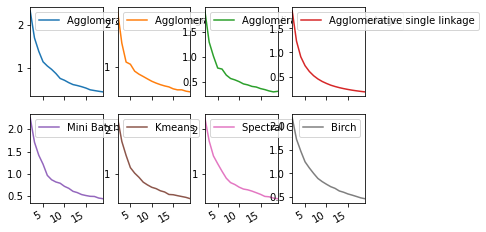

In [104]:
import warnings
warnings.filterwarnings('ignore')
wcss_scores.plot.line(subplots=True, legend=True, layout=(2, 4))

### Wyplotowanie Indeksu Davida-Bouldina

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019EC1C33550>,
      dtype=object)

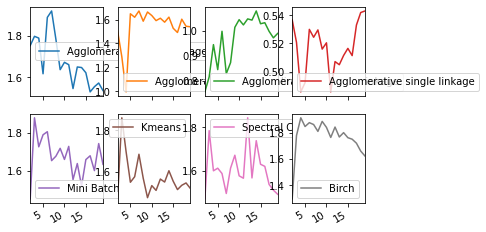

In [105]:
import warnings
warnings.filterwarnings('ignore')
idb_scores.plot.line(subplots=True, legend=True, layout=(2, 4))

### Wyplotowanie miary Silhouette

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019EC1EC8EB8>,
      dtype=object)

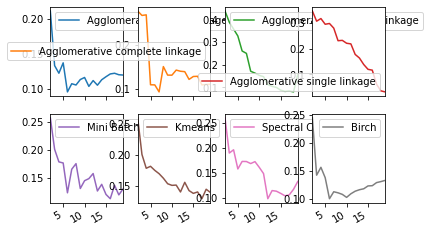

In [106]:
import warnings
warnings.filterwarnings('ignore')
sillhoute_scores.plot.line(subplots=True, legend=True, layout=(2, 4))

### Hipoteza o podziale wg ksiąg

Aby ocenić prawdziwość wcześniej podanej hipotezy, potrzebujemy nazw rodziałów i ksiąg.

In [1]:
import re
f = open('AsianReligionsData/labels.txt')
lcontent = f.read()
llines = lcontent.split("\n")
labels = []

# wybranie tylko linii z danymi
for l in llines:
    labels.append(l)
        
f.close()
labels.pop()
len(labels)

590

In [5]:
labels_general = []
for l in labels:
    labels_search = re.search('(.+)_', l)
    labels_general.append(labels_search.group(1))
len(labels_general)

590

In [29]:
set(labels_general)

{'BookOfEccleasiasticus',
 'BookOfEcclesiastes',
 'BookOfProverb',
 'BookOfWisdom',
 'Buddhism',
 'TaoTeChing',
 'Upanishad',
 'YogaSutra'}

Jak widać, mamy osiem ksiąg. Zmieńmy nazwy na liczby od 0 do 7.

In [50]:
i = -1
labels_true = []
prev = ""
for l in labels_general:
    if l != prev:
        i += 1
    prev = copy.copy(l)
    labels_true.append(copy.copy(i))

Funkcje pomocnicze, zadeklarowane w celu obliczenia metryki.

In [81]:
from sklearn import metrics


def clustering_true_pred_score(X, labels_true, k):
    df = pd.DataFrame()
    for model_key in models:
        model=models[model_key]
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        df.loc[model_key, "adjusted_rand_score"] = metrics.adjusted_rand_score(labels_true, labels)
    return df, labels

In [82]:
wyniki, labels_pred = clustering_true_pred_score(average_sentiments, labels_true, 8)

In [62]:
wyniki

,adjusted_rand_score
Agglomerative ward linkage,0.031006
Agglomerative complete linkage,-0.009290
Agglomerative average linkage,-0.015803
Agglomerative single linkage,-0.003374
Mini Batch KMeans,0.009919
Kmeans,0.019211


Wyniki w żadnym wypadku nie przekraczają nawet 0.032, więc całkiem jasnym jest to, że podział obliczonhy na podstawie analizy sentymentów zupełnie nie pokrywa się z podziałem na księgi. Ze względu na niskie wyniki uznaliśmy, że nie ma potrzeby sprawdzania innych indeksów dla sprawdzenia poprawności.

### Wyplotowanie sentymentów

Oczywiście, można wyplotować wszystkie modele dla wszystkich wartości k, ale o wiele lepszym będzie wybranie "najlepszego" podziału i zaprezentowanie go. W tym celu wykorzystamy Miarę Silhouette.

In [190]:
sillhoute_scores.loc[sillhoute_scores.idxmax()]

,Agglomerative ward linkage,Agglomerative complete linkage,Agglomerative average linkage,Agglomerative single linkage,Mini Batch KMeans,Kmeans,Spectral Clustering,Birch
2,0.210926,0.277539,0.436363,0.347857,0.257529,0.259428,0.259428,0.245159
2,0.210926,0.277539,0.436363,0.347857,0.257529,0.259428,0.259428,0.245159
2,0.210926,0.277539,0.436363,0.347857,0.257529,0.259428,0.259428,0.245159
2,0.210926,0.277539,0.436363,0.347857,0.257529,0.259428,0.259428,0.245159
2,0.210926,0.277539,0.436363,0.347857,0.257529,0.259428,0.259428,0.245159
2,0.210926,0.277539,0.436363,0.347857,0.257529,0.259428,0.259428,0.245159
2,0.210926,0.277539,0.436363,0.347857,0.257529,0.259428,0.259428,0.245159
2,0.210926,0.277539,0.436363,0.347857,0.257529,0.259428,0.259428,0.245159


In [187]:
# i-db jest odwrotnie - im mniej, tym lepiej
idb_scores.loc[idb_scores.idxmin()]

,Agglomerative ward linkage,Agglomerative complete linkage,Agglomerative average linkage,Agglomerative single linkage,Mini Batch KMeans,Kmeans,Spectral Clustering,Birch
16,1.529564,1.491536,1.033655,0.511339,1.678892,1.516245,1.620999,1.752677
4,1.789993,0.995377,0.945434,0.485516,1.726395,1.697025,1.600609,1.916066
2,1.753624,1.507330,0.755073,0.536715,1.451011,1.472556,1.472275,1.298259
4,1.789993,0.995377,0.945434,0.485516,1.726395,1.697025,1.600609,1.916066
2,1.753624,1.507330,0.755073,0.536715,1.451011,1.472556,1.472275,1.298259
2,1.753624,1.507330,0.755073,0.536715,1.451011,1.472556,1.472275,1.298259
2,1.753624,1.507330,0.755073,0.536715,1.451011,1.472556,1.472275,1.298259
2,1.753624,1.507330,0.755073,0.536715,1.451011,1.472556,1.472275,1.298259


Najlepszy okazuje się agglomerative (single linkage) model dla k=4. 
Żeby móc wyplotować 10 wymiarów, należy też najpierw dokonać ich redukcji: 

Text(0.5, 1.0, 'Sentiment Clustering - k = 4')

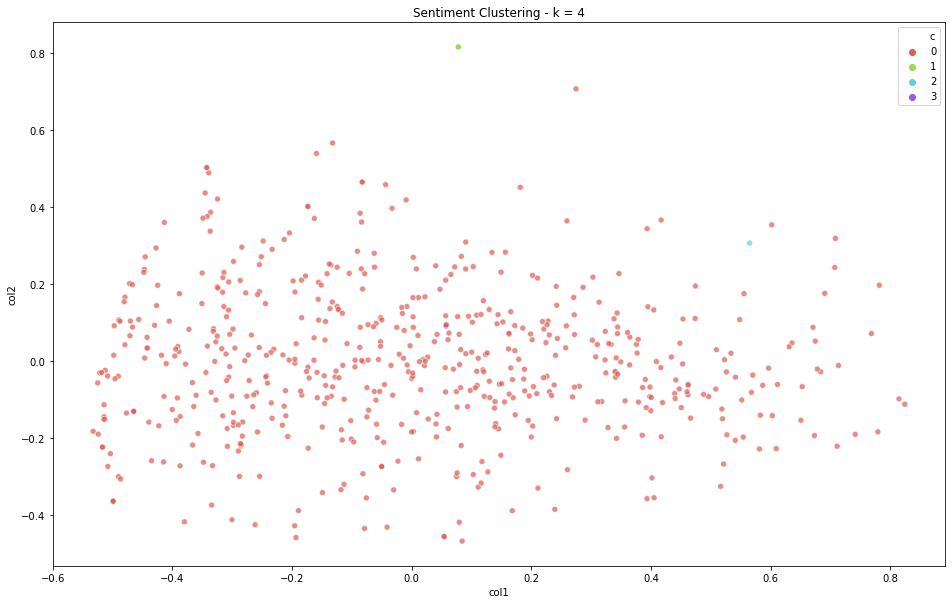

In [193]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca_sc = pca.fit_transform(average_sentiments)
pca_sc_df = pd.DataFrame(data = pca_sc, columns = ['col1', 'col2'])


model_instance = AgglomerativeClustering(n_clusters=4, linkage='single')
labels_pred = model_instance.fit_predict(average_sentiments)
pca_sc_df['c'] = labels_pred
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="col1", y="col2",
    hue="c",
    palette=sns.color_palette("hls", len(set(labels_pred))),
    data=pca_sc_df,
    legend="full",
    alpha=0.7
).set_title("Sentiment Clustering - k = 4")

Nie jest to zbyt motywujące - po prostu jedna duża grupa i pojedyncze obserwacje poza.

Sentymenty można też zaprezentować w nieco inny sposób - poprzez wypisanie średnich wartości sentymentów dla każdego klastra (jest to już po standaryzacji).

In [118]:
from sklearn import preprocessing

x = average_sentiments.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
average_sentiments2 = pd.DataFrame(x_scaled)

from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters = 7, linkage='ward')
etykiety = model.fit_predict(average_sentiments2)
tmp = average_sentiments.iloc[np.where(etykiety==0)]
tmp = tmp.sum()/tmp.shape[0]
cluster_emotions = pd.DataFrame(copy.copy([tmp])) 
for i in range(1, 7):
    tmp = average_sentiments.iloc[np.where(etykiety==i)]
    tmp = tmp.sum()/tmp.shape[0]
    cluster_emotions = cluster_emotions.append(copy.copy([tmp]))

Text(0.5, 1.0, 'Cluster nr 6 - 22 elementów')

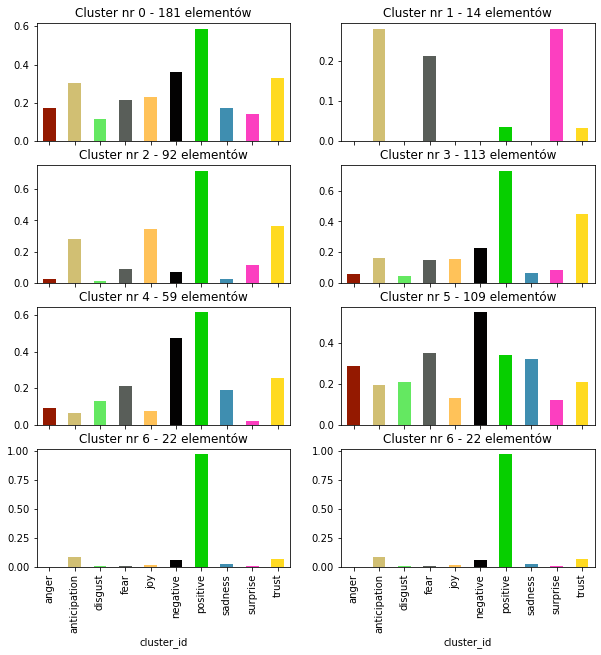

In [162]:
warnings.filterwarnings('ignore')
cluster_emotions = cluster_emotions.rename_axis('cluster_id', axis='columns')
cluster_emotions.index = list(range(0, 7))
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10), sharex=True)
colors = ['#941900', '#d1bf73', '#64e861', '#595e59', '#ffc259', '#030202', '#07cf00', '#3f8eb0', '#fc3fc0', '#ffda21']
labels_series = pd.Series(labels)


for i in range(0, 7):
    cluster_emotions.iloc[i].plot.bar(ax=axes[i//2, i%2], \
                                  color = colors).set_title('Cluster nr '+ str(i) +' - ' + \
                                  str(len(labels_series.iloc[np.where(etykiety==i)])) + ' elementów')

cluster_emotions.iloc[6].plot.bar(ax=axes[3, 1], \
                                  color = colors).set_title('Cluster nr 6 - ' + \
                                str(len(labels_series.iloc[np.where(etykiety==6)])) + ' elementów')

Ostatni wykres jest plotowany dwa razy w celu zachowania symetrii i adekwatnych podpisów pod osiami.

### Druga hipoteza - początek i koniec

Doszliśmy do jescze jednej hipotezy, którą postanowiliśmy sprawdzić - czy po wybraniu pierwszych i ostatnich rozdziałów każdej księgi klastering wg sentymentow zakwalifikuje je poprawnie (czyli: czy dla k=2 rozdziały zostaną poprawnie rozdzielone na "pierwsze" i "ostatnie").

In [138]:
# wyciągnięcie pierwszych i ostatnich rozdziałów każdej księgi
first_chapters = []
last_chapters = []
prev = ""
for i in range(0, len(labels_general)):
    if labels_general[i] != prev:
        first_chapters.append(i)
        if i > 0:
            last_chapters.append(i-1)
    prev = copy.copy(labels_general[i])
last_chapters.append(len(labels_general)-1)

In [150]:
first_last_as = average_sentiments.iloc[first_chapters+last_chapters]
first_last_as_lab_true = [1] * 8 + [2] * 8
wyniki, labels_pred = clustering_true_pred_score(first_last_as, first_last_as_lab_true, 2)

In [151]:
wyniki

,adjusted_rand_score
Agglomerative ward linkage,-0.066667
Agglomerative complete linkage,-0.053512
Agglomerative average linkage,0.000000
Agglomerative single linkage,0.000000
Mini Batch KMeans,-0.066667
Kmeans,-0.053512
Spectral Clustering,-0.053512
Birch,-0.053512


Jak widać, niestety również ta hipoteza okazała się nieprawdziwa.

## Podsumowanie

Celem projektu było przetworzenie i przeanalizowanie zbioru [A study of Asian Religious and Biblical Texts Data Set](https://archive.ics.uci.edu/ml/datasets/A+study+of++Asian+Religious+and+Biblical+Texts) zawierającego święte teksty należące do różnych religii podzielone na rozdziały i próba znalezienia w jego budowie dodatkowych struktur poprzez dokonanie klasteryzacji.

Podeszliśmy do tego problemu na dwa główne sposoby podstawowe dla przetwarzania języka naturalnego:
* reprezentacji rozdziału jako zbioru informacji o częstości występowania poszczególnych słów w tekście rozdziału
* reprezentacji rozdziału jako zbioru informacji o wartości tzw. sentymentów słów w tekście rozdziału

Analiza i klastrowanie sentymentów nie przyniosły satysfakcjonujących wyników. Po ręcznej analizie zbioru można było dostrzec znaczące odchylenia wartości pojedynczych emocji lub grup emocji definiujących zbiór ksiąg z analizowanego archiwum, ale mimo wszystko wartości te były do siebie zbliżone z uwagi na niewątpliwe występowanie wspólnych kluczowych elementów we wszystkich tekstach. Ostatecznie struktura, którą podpowiadała nam błędna intuicja, była zbyt niewyraźna, by mogła zostać uchwycona przez zastosowane przez nas algorytmy klastrujące i zdecydowanie nie pokrywała się z rzeczywistym podziałem na księgi.

Dużo lepsze efekty dało zastosowanie algorytmów klastrujących na zbiorze informacji o częstości występowania słów w rozdziałach, co potwierdzały zastosowane przez nas miary efektywności klastrowania, m.in. najpopularniejsze jak indeks Daviesa-Bouldina i miara $silhouette$.
Szczególnie zachęcające wydały się wyniki algorytmu GMM zastosowanego do utworzenia 8 klastrów (tylu, ile jest różnych ksiąg w zbiorze!).

Po zastosowaniu i analizie 8 różnych modeli o różnych parametrach na dwóch reprezentacjach zadanego zbioru nie zdołaliśmy ostatecznie zidentyfikować struktury ukrytej w danych, a tym bardziej pokrywającej się z podziałem wynikającym z przynależności poszczególnych rozdziałów do konkretnej księgi. Biorąc pod uwagę unikalny charakter analizowanego zbioru możliwe jest, że taka struktura nie istnieje lub do znalezienia jej wymagane jest dużo bardziej wyrafinowane podejście do problemu. 

## Oświadczenie
Oświadczam, że niniejsza praca stanowiąca podstawę do uznania osiągnięcia efektów uczenia się z przedmiotu Wstęp do Uczenia Maszynowego została wykonana przeze mnie samodzielnie.

Kacper Staroń 298842

Jakub Szypuła 298845

Anna Urbala 298847